In [1]:
# Imports
# !pip install torchinfo
import torch
import torch.nn as nn
import torch.utils.data as Data
from torchvision import datasets, transforms
from torchinfo import summary
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import time
import TrainerVTS_V08C1 as TP
import DataSetting_v2 as DS

In [2]:
%%html
<style>
.cell-output-ipywidget-background {
    background-color: transparent !important;
}
:root {
    --jp-widgets-color: var(--vscode-editor-foreground);
    --jp-widgets-font-size: var(--vscode-editor-font-size);
}
</style>

### Loader

In [8]:
gpu = 5
date = '240523'
#run = ['30', '100', '300', '900']
run = '30'
exp = 'Prop-Teacher'

In [4]:
datadir = f'../dataset/0509/make19_{run}-finished/'
data = DS.ModalityLoader(data_dir=datadir, mmap_mode='r')
train = data.profiling({'T01', 'T02'})
test = data.profiling({'T03', 'T04'})
train_set = DS.MyDataset('tv', train)
test_set = DS.MyDataset('test', test)
train_loader, valid_loader = DS.DataSplitter(train_set).split_loader()
test_loader = DS.DataSplitter(test_set, 1).gen_loader()

Loading from ../dataset/0509/make19_30-finished/


  0%|          | 0/10 [00:00<?, ?it/s]

Profiled by {'T01', 'T02'}
Profiled by {'T03', 'T04'}
Generating loaders...
 tv len 5490, distributed=False
 exported train loader of len 68, batch size 64
 exported valid loader of len 17, batch size 64

Generating loaders...
 test len 5069, distributed=False
 exported loader of len 5069, batch size 1


### Teacher

In [9]:
torch.cuda.set_device(gpu)
imgencoder = TP.ImageEncoder(latent_dim=16)
imgdecoder = TP.ImageDecoder(latent_dim=16)

T_trainer = TP.TeacherTrainer(beta=0.5, 
                              mask=True,
                              recon_lossfunc=nn.MSELoss(reduction='sum'),
                              name='Teacher', networks=[imgencoder, imgdecoder],
                 lr=1e-4, epochs=10, cuda=gpu,
                 train_loader=train_loader, valid_loader=valid_loader, test_loader=test_loader,
                             notion=f"{date}_{run}_{exp}")

Teacher train: epoch=1/999, batch=0/68, loss=4060.6167, current best valid loss=inf    
Teacher train: epoch=1/999, batch=5/68, loss=3975.4180, current best valid loss=inf    
Teacher train: epoch=1/999, batch=10/68, loss=3599.8943, current best valid loss=inf    
Teacher train: epoch=1/999, batch=15/68, loss=2771.5540, current best valid loss=inf    
Teacher train: epoch=1/999, batch=20/68, loss=2643.0933, current best valid loss=inf    
Teacher train: epoch=1/999, batch=25/68, loss=2089.7427, current best valid loss=inf    
Teacher train: epoch=1/999, batch=30/68, loss=1828.0068, current best valid loss=inf    
Teacher train: epoch=1/999, batch=35/68, loss=1519.3511, current best valid loss=inf    
Teacher train: epoch=1/999, batch=40/68, loss=1317.3024, current best valid loss=inf    
Teacher train: epoch=1/999, batch=45/68, loss=1405.3029, current best valid loss=inf    
Teacher train: epoch=1/999, batch=50/68, loss=1110.3817, current best valid loss=inf    
Teacher train: epoch=1/

<Figure size 432x288 with 0 Axes>

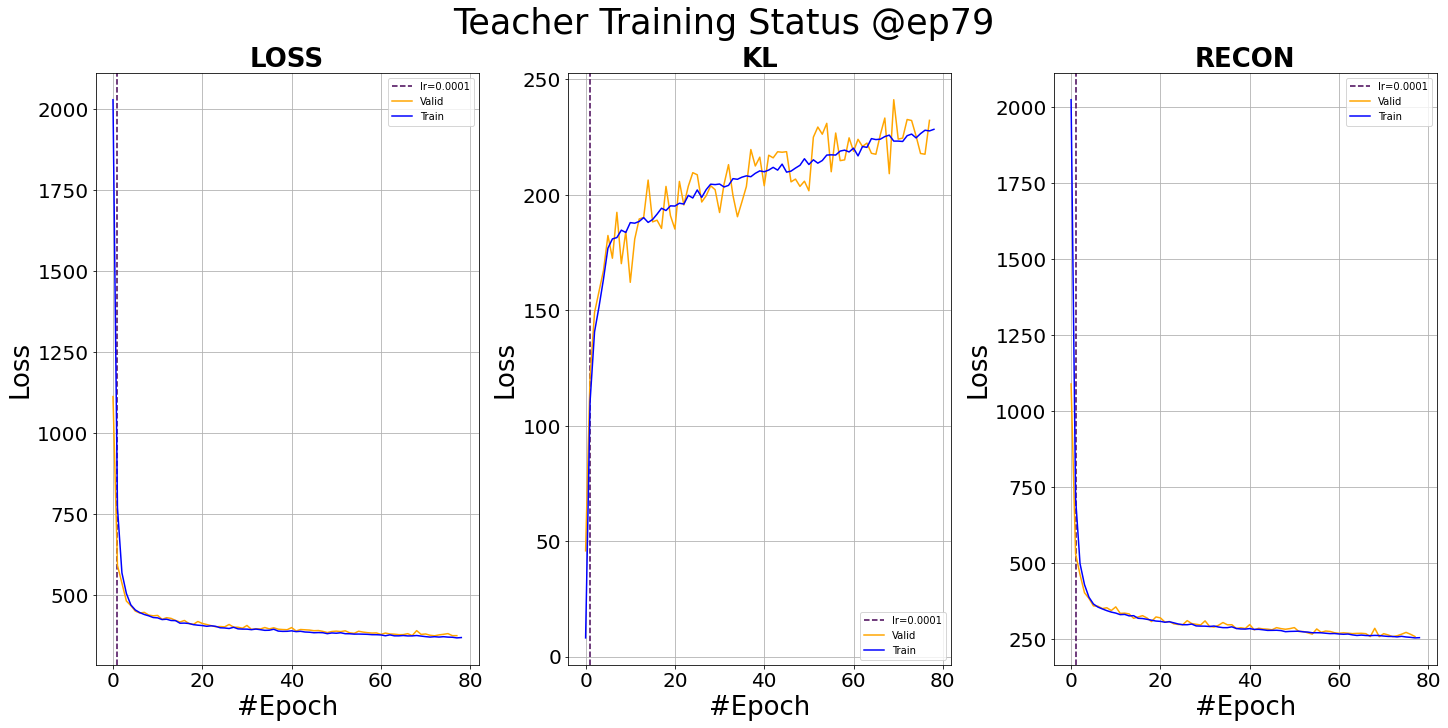

Teacher test: sample=5065/5069, loss=1836.6882    
Test finished. Average loss={'LOSS': 576.3645578980046, 'KL': 3.310378889144819, 'RECON': 574.7093681490476}

Total training time: 77.25284600257874 sec


<Figure size 1440x720 with 0 Axes>

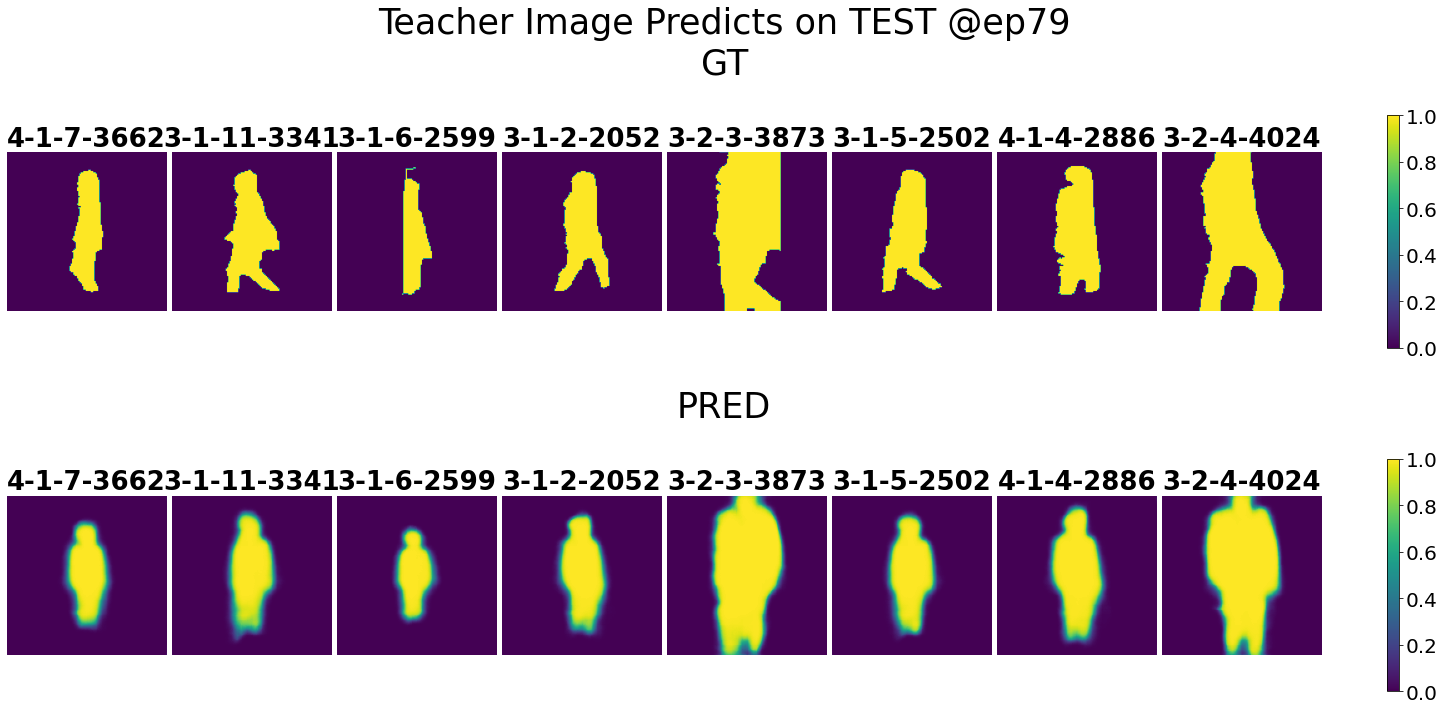

<Figure size 1440x720 with 0 Axes>

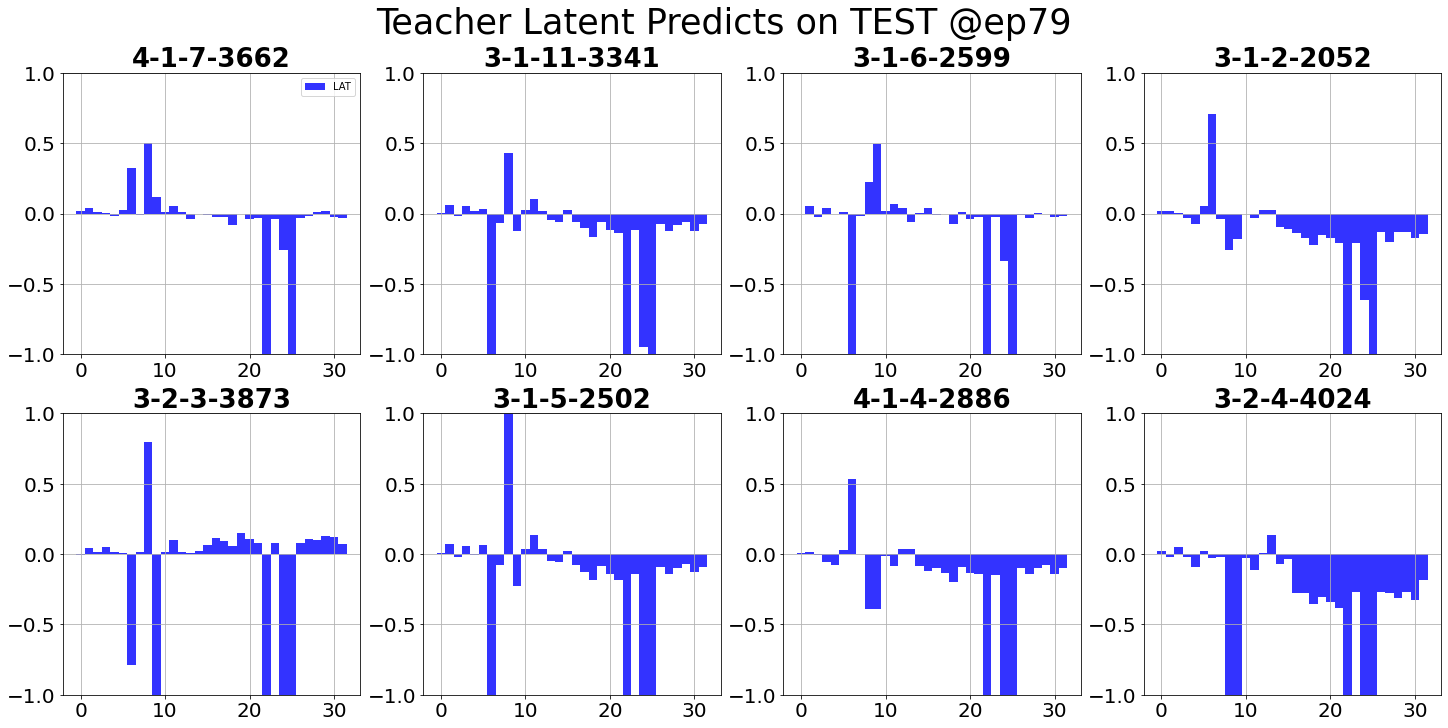

Teacher test: sample=5065/5069, loss=692.3759     
Test finished. Average loss={'LOSS': 577.304579529543, 'KL': 3.310378889144819, 'RECON': 575.6493897429583}

Total training time: 76.28391313552856 sec


<Figure size 1440x720 with 0 Axes>

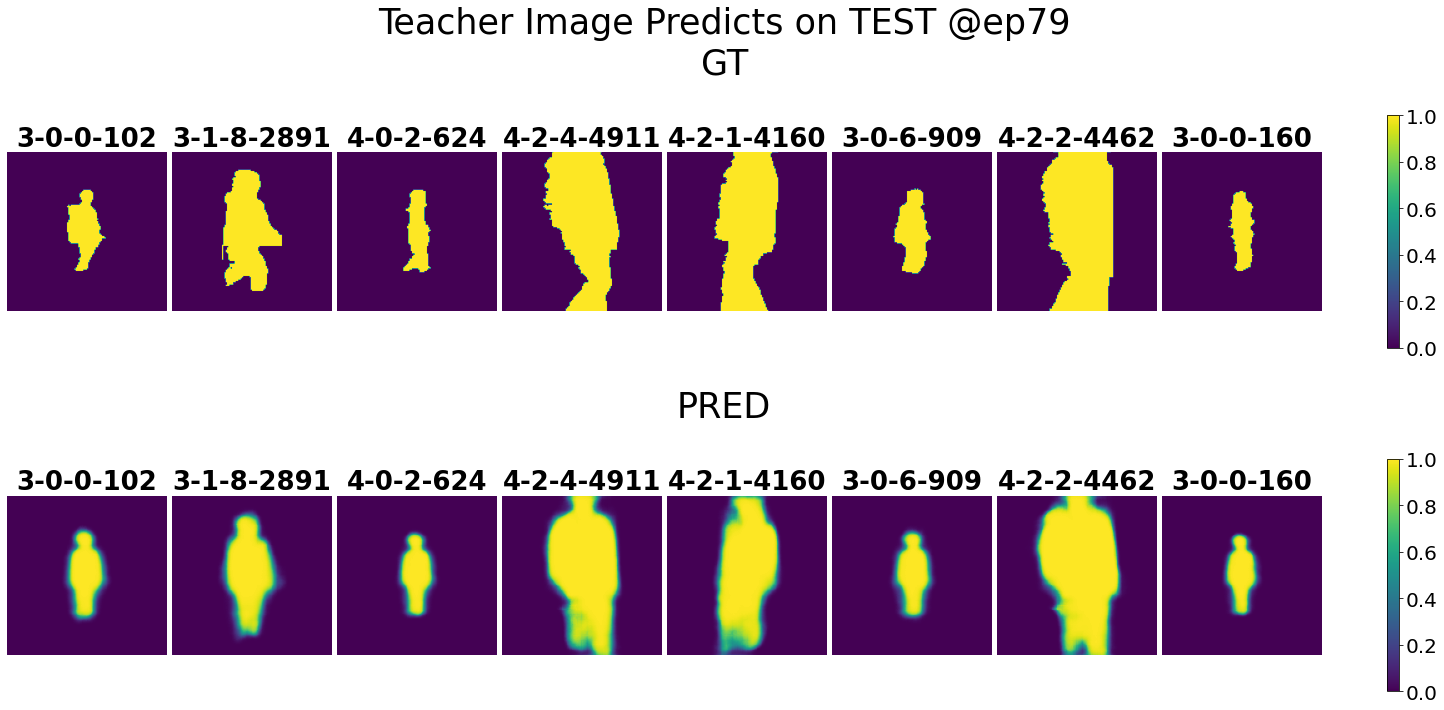

<Figure size 1440x720 with 0 Axes>

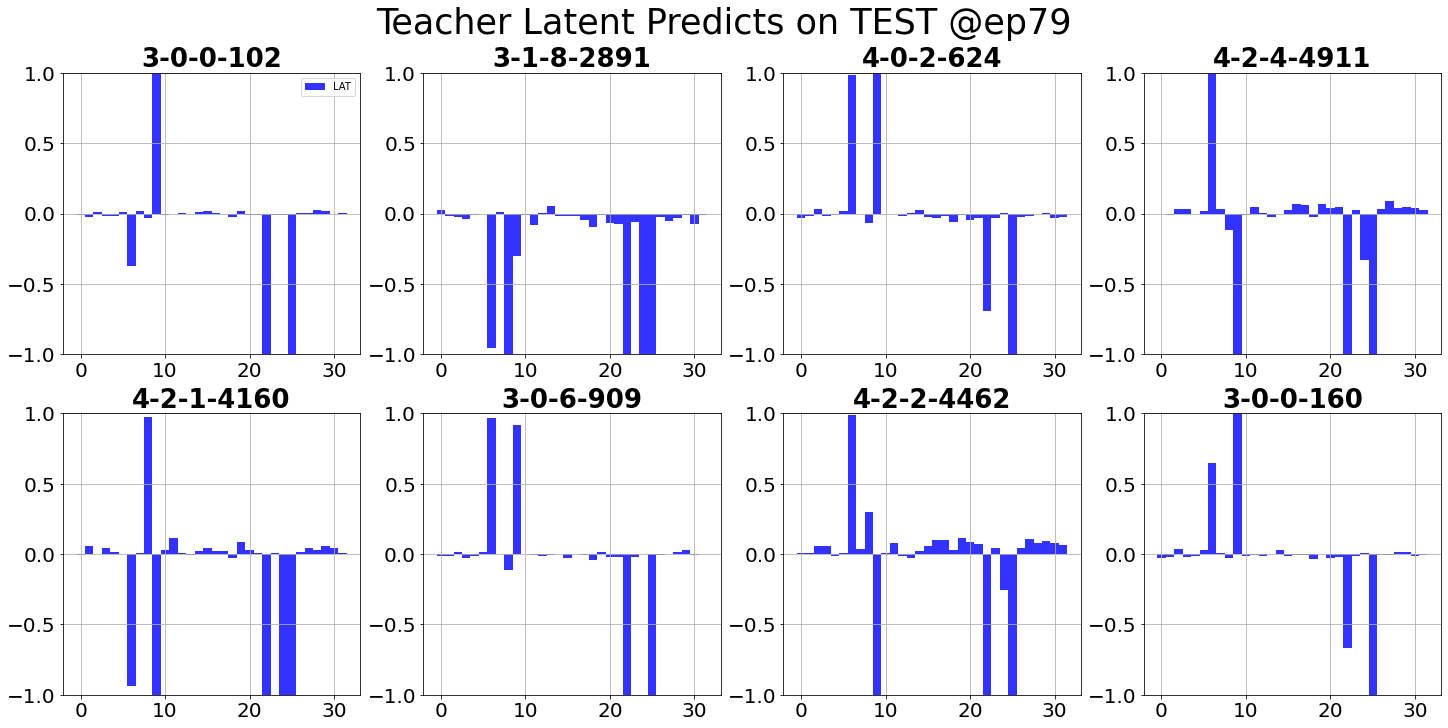

Saving pred including GT, PRED, LAT, TAG...Done

Teacher schedule Completed!


In [10]:
### Scheduler
%matplotlib inline
T_trainer.lr = 1e-4
T_trained = T_trainer.schedule(lr_decay=False)

In [11]:
print(T_trainer.loss.dataset)

TEST


### Student

#### Train

In [ ]:
torch.cuda.set_device(gpu)
csiencoder = TP.CSIEncoder(lstm_steps=225)
centerdecoder = TP.CenterDecoder()
imgencoder = TP.ImageEncoder(latent_dim=16)
imgdecoder = TP.ImageDecoder(latent_dim=16)
imgencoder.load_state_dict(torch.load(f"../saved/240512_30D/240512_30_Teacher_IMGENV07D1@ep167.pth"))
imgdecoder.load_state_dict(torch.load(f"../saved/240512_30D/240512_30_Teacher_IMGDEV07D1@ep167.pth"))

S_trainer = TP.StudentTrainer(name='Student', mask=True,
                              networks=[csiencoder, centerdecoder, imgencoder, imgdecoder],
                              lr=1e-4, epochs=10, cuda=gpu,
                              notion=f"{date}_{run}C",
                              train_loader=train_loader, valid_loader=valid_loader, test_loader=test_loader)

In [ ]:
### Scheduler
%matplotlib inline
S_trained = S_trainer.train(autosave=True, notion=f"{date}_{run}C", train_module={'csien', 'ctrde'}, eval_module={'imgen', 'imgde'})
S_trainer.plot_train_loss(autosave=True, notion=f"{date}_{run}C")

In [ ]:
S_trainer.test(loader='train')
S_trainer.plot_test(select_num=8, autosave=True, notion=f"{date}_{run}C")

In [ ]:
S_trainer.test(loader='test')
S_trainer.plot_test(select_num=8, autosave=True, notion=f"{date}_{run}C")

In [ ]:
S_trainer.loss.save('pred', f"{date}_{run}C")